In [1]:
from idc_index import index
import ipywidgets as widgets
from pathlib import Path
from pydicom import dcmread
from tqdm.notebook import tqdm
import subprocess
from imgtools.dicom.sort import DICOMSorter
from imgtools.logging import logger as imgtools_logger

imgtools_logger.setLevel("WARNING")

In [2]:
client = index.IDCClient()
print(client.get_idc_version())

v17


In [3]:
collections = sorted(client.get_collections())
print(f"Found {len(collections)} collections")  
client.collection_summary

Found 142 collections


,Modality,series_size_MB
collection_id,,
4d_lung,"[RTSTRUCT, CT]",183054.14
acrin_6698,"[MR, SEG]",841956.27
acrin_contralateral_breast_mr,"[MR, CR]",199592.57
acrin_flt_breast,"[PT, CT, OT]",74235.64
acrin_nsclc_fdg_pet,"[PT, CT, DX, CR, NM, MR, SC, SEG]",145677.88
...,...,...
tcga_uvm,[SM],102250.70
upenn_gbm,[MR],139399.35
vestibular_schwannoma_mc_rc,[MR],10015.97


# Filter Collections have both RTSTRUCTS and CTs

In [4]:
# Group by collection_id and aggregate the Modality column
grouped = client.index.groupby('collection_id')['Modality'].apply(lambda x: set(x))

# Filter collection_ids where both RTSTRUCT and CT exist in the Modality set
rt_ct_collections = grouped[grouped.apply(lambda x: 'RTSTRUCT' in x and 'CT' in x)]

print(f"Found {len(rt_ct_collections)} collections with both RTSTRUCT and CT")
rt_ct_collections

Found 13 collections with both RTSTRUCT and CT


collection_id
4d_lung                                           {RTSTRUCT, CT}
cc_tumor_heterogeneity               {MR, PT, RTSTRUCT, REG, CT}
cptac_ccrcc                               {RTSTRUCT, CT, MR, SM}
cptac_pda                         {MR, PT, RTSTRUCT, SM, CT, US}
cptac_ucec                            {MR, PT, RTSTRUCT, SM, CT}
lctsc                                             {RTSTRUCT, CT}
nsclc_radiomics                          {CT, SEG, SR, RTSTRUCT}
nsclc_radiomics_interobserver1               {CT, SEG, RTSTRUCT}
pancreatic_ct_cbct_seg                    {CT, RTDOSE, RTSTRUCT}
pediatric_ct_seg                                  {CT, RTSTRUCT}
prostate_anatomical_edge_cases                    {RTSTRUCT, CT}
rider_lung_ct                        {SEG, PR, RTSTRUCT, CT, SR}
soft_tissue_sarcoma                       {RTSTRUCT, CT, MR, PT}
Name: Modality, dtype: object

# Select a Collection to explore from the dropdown menu below.

The default is `4d_lung`

In [9]:
collection_list = rt_ct_collections.index

collection_widget = widgets.Dropdown(
    options=collection_list,
    description='Collection:',
    value='4d_lung',
    disabled=False,
)
display(collection_widget)

Dropdown(description='Collection:', options=('4d_lung', 'cc_tumor_heterogeneity', 'cptac_ccrcc', 'cptac_pda', …

In [10]:
matching_series = client.index.loc[client.index.collection_id == collection_widget.value, ['SeriesInstanceUID', 'Modality', "series_size_MB"]]
print(f"Found {len(matching_series)} series in collection {collection_widget.value}")
options=[
  (
    f'SeriesUID-{row['SeriesInstanceUID'][-10:]} [Modality: {row["Modality"]}; Size: {row["series_size_MB"]}MB]',
    row["SeriesInstanceUID"]
  )
  for _, row in matching_series.iterrows()
  if row['Modality'] == 'RTSTRUCT'
]

rt_widget = widgets.Dropdown(
    options=options,
    description='Series:',
    layout={'width': 'max-content'},
    disabled=False,
)
display(rt_widget)

Found 6690 series in collection 4d_lung


Dropdown(description='Series:', layout=Layout(width='max-content'), options=(('SeriesUID-1074172.68 [Modality:…

In [11]:
print(f"Selected RTSTRUCT Series: {rt_widget.value}")

Selected RTSTRUCT Series: 2.25.301560857511085372174077181327491074172.68


In [12]:
rt_url = client.get_series_file_URLs(rt_widget.value)[0]
s5cmd = client.s5cmdPath

TMP_DIR = Path("data") / "tmp"
TMP_DIR.mkdir(parents=True, exist_ok=True)
print("Downloading RTSTRUCT file...")
! $s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com cp --show-progress  $rt_url $TMP_DIR

rt_path = TMP_DIR.iterdir().__next__()
print(f"Downloaded RTSTRUCT file to {rt_path}")

ds = dcmread(rt_path, stop_before_pixels=True, specific_tags=['ReferencedFrameOfReferenceSequence', 'StructureSetROISequence'])

referenced_ct = ds.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].SeriesInstanceUID
print(f"Referenced CT Series: {referenced_ct}")

ct_urls = client.get_series_file_URLs(referenced_ct)

for ct_url in tqdm(ct_urls, desc="Downloading CT files"):
  subprocess.run([s5cmd, "--no-sign-request", "--endpoint-url", "https://s3.amazonaws.com", "sync", ct_url, TMP_DIR])

100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  35.58 kB / 35.58 kB ? p/s 100ms (1/1)
Downloaded RTSTRUCT file to data/tmp/0b45f1fd-0ca7-45b7-907b-c089f03abda4.dcm
Referenced CT Series: 1.3.6.1.4.1.14519.5.2.1.6834.5010.102021682875249184391293522170


cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/00b68307-66d7-4baf-a6aa-0a12c5572336.dcm data/tmp/00b68307-66d7-4baf-a6aa-0a12c5572336.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/0108ff97-bac8-4411-bb15-912e2975063c.dcm data/tmp/0108ff97-bac8-4411-bb15-912e2975063c.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/04113e7e-3afc-41fb-b58a-2e5dd525b701.dcm data/tmp/04113e7e-3afc-41fb-b58a-2e5dd525b701.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/058ebbc6-cd4c-492b-bf31-990aac93cf55.dcm data/tmp/058ebbc6-cd4c-492b-bf31-990aac93cf55.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/05f91828-b284-4516-b52d-8b52c80adfc1.dcm data/tmp/05f91828-b284-4516-b52d-8b52c80adfc1.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/06da7fdf-6df9-4f36-9bc3-2103bca4ca02.dcm data/tmp/06da7fdf-6df9-4f36-9bc3-2103bca4ca02.dcm
cp s3://idc-open-data/fb556b73-d1be-4b03-b42f-2291b5ea2d38/0936f9c6-9be7-46ef-8373-e4fe31a25d36.dcm 

In [13]:


sorted_path = TMP_DIR.parent / collection_widget.value

if sorted_path.exists():
  raise FileExistsError(f"Sorted Path Exists, please remove `{sorted_path}`")

dicomsorter = DICOMSorter(
  source_directory=TMP_DIR.absolute(),
  target_pattern=Path(
    sorted_path,
    "Patient-%PatientID/StudyUID-%StudyInstanceUID/%Modality-SeriesUID%SeriesInstanceUID/"
  ).as_posix(),
)
dicomsorter.execute(action="symlink")

print("New Directory Structure: ")
! tree -d $(TMP_DIR.parent.absolute() / collection_widget.value) 

Output()

Output()

New Directory Structure: 
.
└── data
    ├── 4d_lung
    │   └── Patient-117_HM10395
    │       └── StudyUID-01309
    │           ├── CT-SeriesUID22170
    │           └── RTSTRUCT-SeriesUID72.68
    └── tmp

8 directories


In [ ]:
from readii.image_processing import displayCTSegOverlay
from readii.loaders import loadDicomSITK, loadRTSTRUCTSITK

ct_dir = sorted_path.rglob("**/CT*/").__next__()
rt_file = sorted_path.rglob("**/RTSTRUCT*/*.dcm").__next__()

assert ct_dir.is_dir() and rt_file.is_file()

ct = loadDicomSITK(ct_dir)

seg_dict = loadRTSTRUCTSITK(rt_file, ct_dir)
roi_picker = widgets.Dropdown(
    options=list(seg_dict.keys()),
    description='ROI:',
    layout={'width': 'max-content'},
    disabled=False,
)
display(roi_picker)

Dropdown(description='ROI:', layout=Layout(width='max-content'), options=('Tumor_c70', 'LN_c70', 'Carina_c70',…

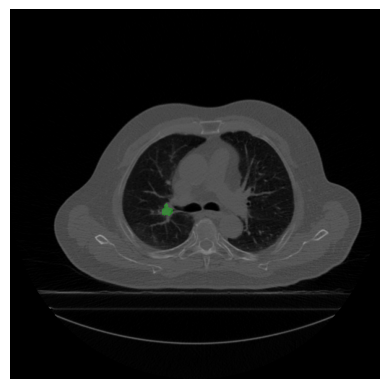

In [15]:
seg = seg_dict[roi_picker.value]
num_slices = ct.GetSize()[2]

displayCTSegOverlay(
  ctImage=ct,
  segImage=seg,
  sliceIdx=-1,
)